# Medical image segmentation with deep learning

Welcome to our hands-on session on medical image segmentation with deep learning! During this session you will study in depth and apply the very popular deep learning U-Net architecture to perform the segmentation of 2D ultrasound images. This is a 30-years old problem which has taken an important step forward thanks to deep learning techniques. This session is based on a study we (Creatis lab.) recently published in IEEE transactions on Medical Imaging (DOI: 10.1109/TMI.2019.2900516). To provide answers to the problem of echocardiographic image segmentation by deep learning methods, we have set up a substantial open access dataset, named CAMUS, composed of 500 patients with two types of acquisitions: two-chamber and four-chamber views. During this hands-on session, you will use only a fraction of this dataset (restricted to four-chamber view acquisitions from 200 patients) to make the different learning phases feasible within the framework of this session. However, if you want to go further on this topic after this spring school, don't hesitate to download the full dataset and play with it! You will find all the necessary information at the following web address: http://camus.creatis.insa-lyon.fr/challenge/

This hands-on session will:
- allow you to study how to code a deep learning segmentation method with the Keras library (tensorflow backend)
- give you hindsights on good practices when programming such deep learning architectures


**Instructions:**
- We recommend that you write your answers directly on this notebook. You will be able to retrieve the whole code for your personal use by simply saving this notebook (*.ipynb file) on your local session and then send it to your email account.

**You will learn to:**
- Use (program) the fundamental steps to design the architecture of a deep learning algorithm from the Keras library, including:
    - Preprocessing the input data  
    - Defining a deep learning model
    - Setting up callback functions to better investigate the training phase 
    - tuning different key parameters and study their influence
- Explore more advanced concepts to begin to demystify the black box effect of deep learning.


***

## Deep learning U-Net architecture

U-Net is one of the most famous deep learning architecture used for image segmentation in medical imaging. It has been created by by Olaf Ronneberger, Philipp Fischer and Thomas Brox in 2015 at the paper "UNet: Convolutional Networks for Biomedical Image Segmentation" (DOI: 10.1007/978-3-319-24574-4_28). The original architecture proposed in 2015 is given below.

<br><img src="notebook_illustrations/u-net-architecture.png" style="width:700px;height:466px;"><br>

The network consists of a contracting path and an expansive path, which gives it the u-shaped architecture. The contracting path is a typical convolutional network that consists of repeated application of convolutions, each followed by a rectified linear unit (ReLU) and a max pooling operation. During the contraction, the spatial information is reduced while feature information is increased. The expansive pathway combines the feature and spatial information through a sequence of up-convolutions and concatenations with high-resolution features from the contracting path. For more information, don't hesitate to visit the official website at https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

<br>

In this hands-on session, we will use this U-Net architecture to segment 2D echocardiography images. In particular, we will focus on the segmentation of three adjacent cardiac structures: the left ventricle, the myocardium and the right ventricle. An illustration of the segmentation (image on the right) of a typical case (image on the left) is given below. As you can see, the segmentation of these ultrasound images is particularly difficult due to many sources of artifacts, the recognition of the structures to segment, and the subjective delineation of the contours (e.g. at the lower part of the myocardial segmentation mask).  

<br><img src="notebook_illustrations/us_seg_illustration.png" style="width:735px;height:341px;"><br>


***

## Table of Contents
 <p><div class="lev1 toc-item"><a href="#packages">1&nbsp;&nbsp;Packages</a></div><div class="lev1 toc-item"><a href="#dataset">2&nbsp;&nbsp;Dataset (estimated time: 10 minutes)</a></div><div class="lev1 toc-item"><a href="#architecture_unet">3&nbsp;&nbsp;Definition of the architecture of a U-Net model (estimated time: 40 minutes)</a></div><div class="lev1 toc-item"><a href="#training_phase">4&nbsp;&nbsp;Training phase (estimated time: 40 minutes)</a></div><div class="lev1 toc-item"><a href="#training_optimization">5&nbsp;&nbsp;Training optimization (estimated time: 30 minutes)</a></div><div div class="lev1 toc-item"><a href="#unet_optimization">6&nbsp;&nbsp;U-Net architecture optimization (estimated time: 30 minutes)</a></div><div div class="lev1 toc-item"><a href="#to_go_further">7&nbsp;&nbsp;To go further (estimated time: remaining time)</a></div>

***

<a id='packages'></a>
## 1 - Packages

First, let's run the cell below to import all the packages that you will need during this session. 
- [keras](https://keras.io/) is a high-level neural networks API, written in Python and capable of running on top of TensorFlow. It provides high-level built-in functions which simplify the design of deep learning architectures (https://keras.io/why-use-keras/).
- [tensorflow](https://keras.io/) is a Python library for fast numerical computing created and released by Google that can be used to create deep learning models directly or by using wrapper libraries that simplify the process built on top of TensorFlow such as keras.

- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [medpy](http://loli.github.io/medpy/) is a library dedicated to medical imaging in Python.

In [1]:
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import *
from keras.models import Model
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline
!pip install medpy 

Using TensorFlow backend.


    100% |████████████████████████████████| 153kB 11.2MB/s 
    100% |████████████████████████████████| 42.5MB 1.3MB/s 
  Running setup.py bdist_wheel for medpy ... done
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy
menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 3.0.2 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.4.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


<br>
In order to make the hands-on session more fluent, we have coded our own python modules. Some of these modules contain functions that call others keras functions. So, for participants who are not comfortable with python programming, we invite you to focus on running the cells of the notebook and analyze the generated results. For the others, we invite you to regularly take a look at the functions present in our modules (loadable from the file explorer) in order to analyze how the different functionalities we developed have been developed. 

Let's run the cell below to import our own modules that you will need during this session. 


In [3]:
from sources.model import unet
from sources.dataset import load_camus
from sources.metrics_and_losses import multiclass_dice, classes_dice_loss
from sources.evaluation import get_geometrical_results, display_mean_values_of_metrics, display_histogram_of_metrics
from sources.utils import LossHistory, display_dataset_samples
from sources.utils import display_loss_metric_curves, display_dataset_samples_with_estimation 
from sources.utils import display_model_weights, display_model_feature_maps

***

<a id='dataset'></a>
## 2 - Dataset
    => estimated time: 10 minutes

We'll first mount the dataset we will use and also a few pretrained models. In order to do that, on the right tab "Add datasets", enter the following :
- Data : "ge-insa-lyon/datasets/camus_dataset/2"  
- Mount directory : "camus_dataset" (default) -> Attach dataset
- Data : "ge-insa-lyon/datasets/camus_pretrained_models/1"
- Mount directory : "camus_pretrained_models" (default) -> Attach dataset


As presented in the introduction of this hands-on session, you will use a subset of the CAMUS dataset restricted to four-chamber view acquisitions from 200 patients. The dataset will be split into three folds:

- ***a training set*** (x_train,y_train) representing 50% of the full dataset. x_train contains a list of the input image will y_train contains a list of the corresponding reference masks 
- ***a validation set*** (x_val,y_val) representating 25% of the full dataset. This dataset will be used to select the network parameters which produce the best results on the training dataset.
- ***a testing set*** (x_test, y_test) representing 25% of the full dataset. This dataset will be used to assess the scores that can reach the trained network on unseen data.

**Instructions**: Let's get more familiar with the dataset. Load the different dataset by running the cell below.

In [4]:
# Parameters
data_path = '/floyd/input/camus_dataset' # path to the dataset on floydhub
train_ind = range(300, 400)
val_ind = range(400, 450)
test_ind = range(450, 500)

# Call "load_camus" function to load data present on the data_path folder.
# The second argument provides the list of indices to load a set of data
# The third argument forces to resize each image with the given values
# For more information on this function, go and explore it !
(x_train, y_train) = load_camus(data_path, train_ind, size=(256, 256))
(x_val, y_val) = load_camus(data_path, val_ind, size=(256, 256))
(x_test, y_test) = load_camus(data_path, test_ind, size=(256, 256))

Loading images from .png files ... 
 Done ! 
Loading images from .png files ... 
 Done ! 
Loading images from .png files ... 
 Done ! 



**Exercise**: The following lines allow you to see the size of the loaded training input images and references stored in the x_train and y_train variables. Execute it and modify it to also investigate the size of the validation and testing dataset.

In [5]:
print("Size of X: ", x_train.shape, " || size of Y : ", y_train.shape)

Size of X:  (200, 256, 256, 1)  || size of Y :  (200, 256, 256, 4)


**Comments**: The last dimension of the y_train is 4. Indeed, in tensorflow/keras implementation, it is necessary to provide one binary channel per class to segment. Since we want to segment three different structures in this project (left ventricle, myocardium and left atrium), we set 4 channels, one for each structure plus one for the background. 

**Excercice**: Execute the following code to better assess this notion of channel. In particular select different channel and see the corresponding image.  

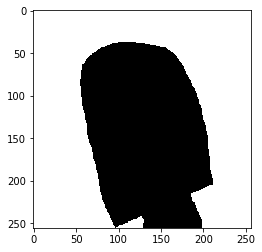

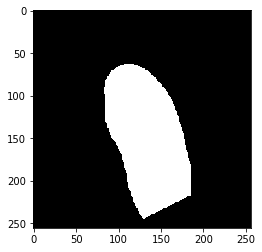

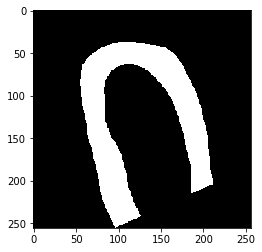

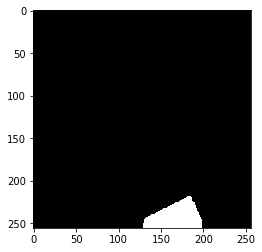

In [18]:
#ind_channel = 4  # indice of channel
for ind_channel in range(0,4):
    img = y_train[0,:,:,ind_channel]
    plt.figure()
    plt.imshow(img, cmap="gray")
    plt.show()

**Instructions**: Let's visualize the dataset for different samples by executing the following cell. Feel free re-run the cell multiple times to see other images. For those interested with Python programming, don't hesitate to analyze the code of the *display_dataset_samples* function defined in the file *utils.py*.

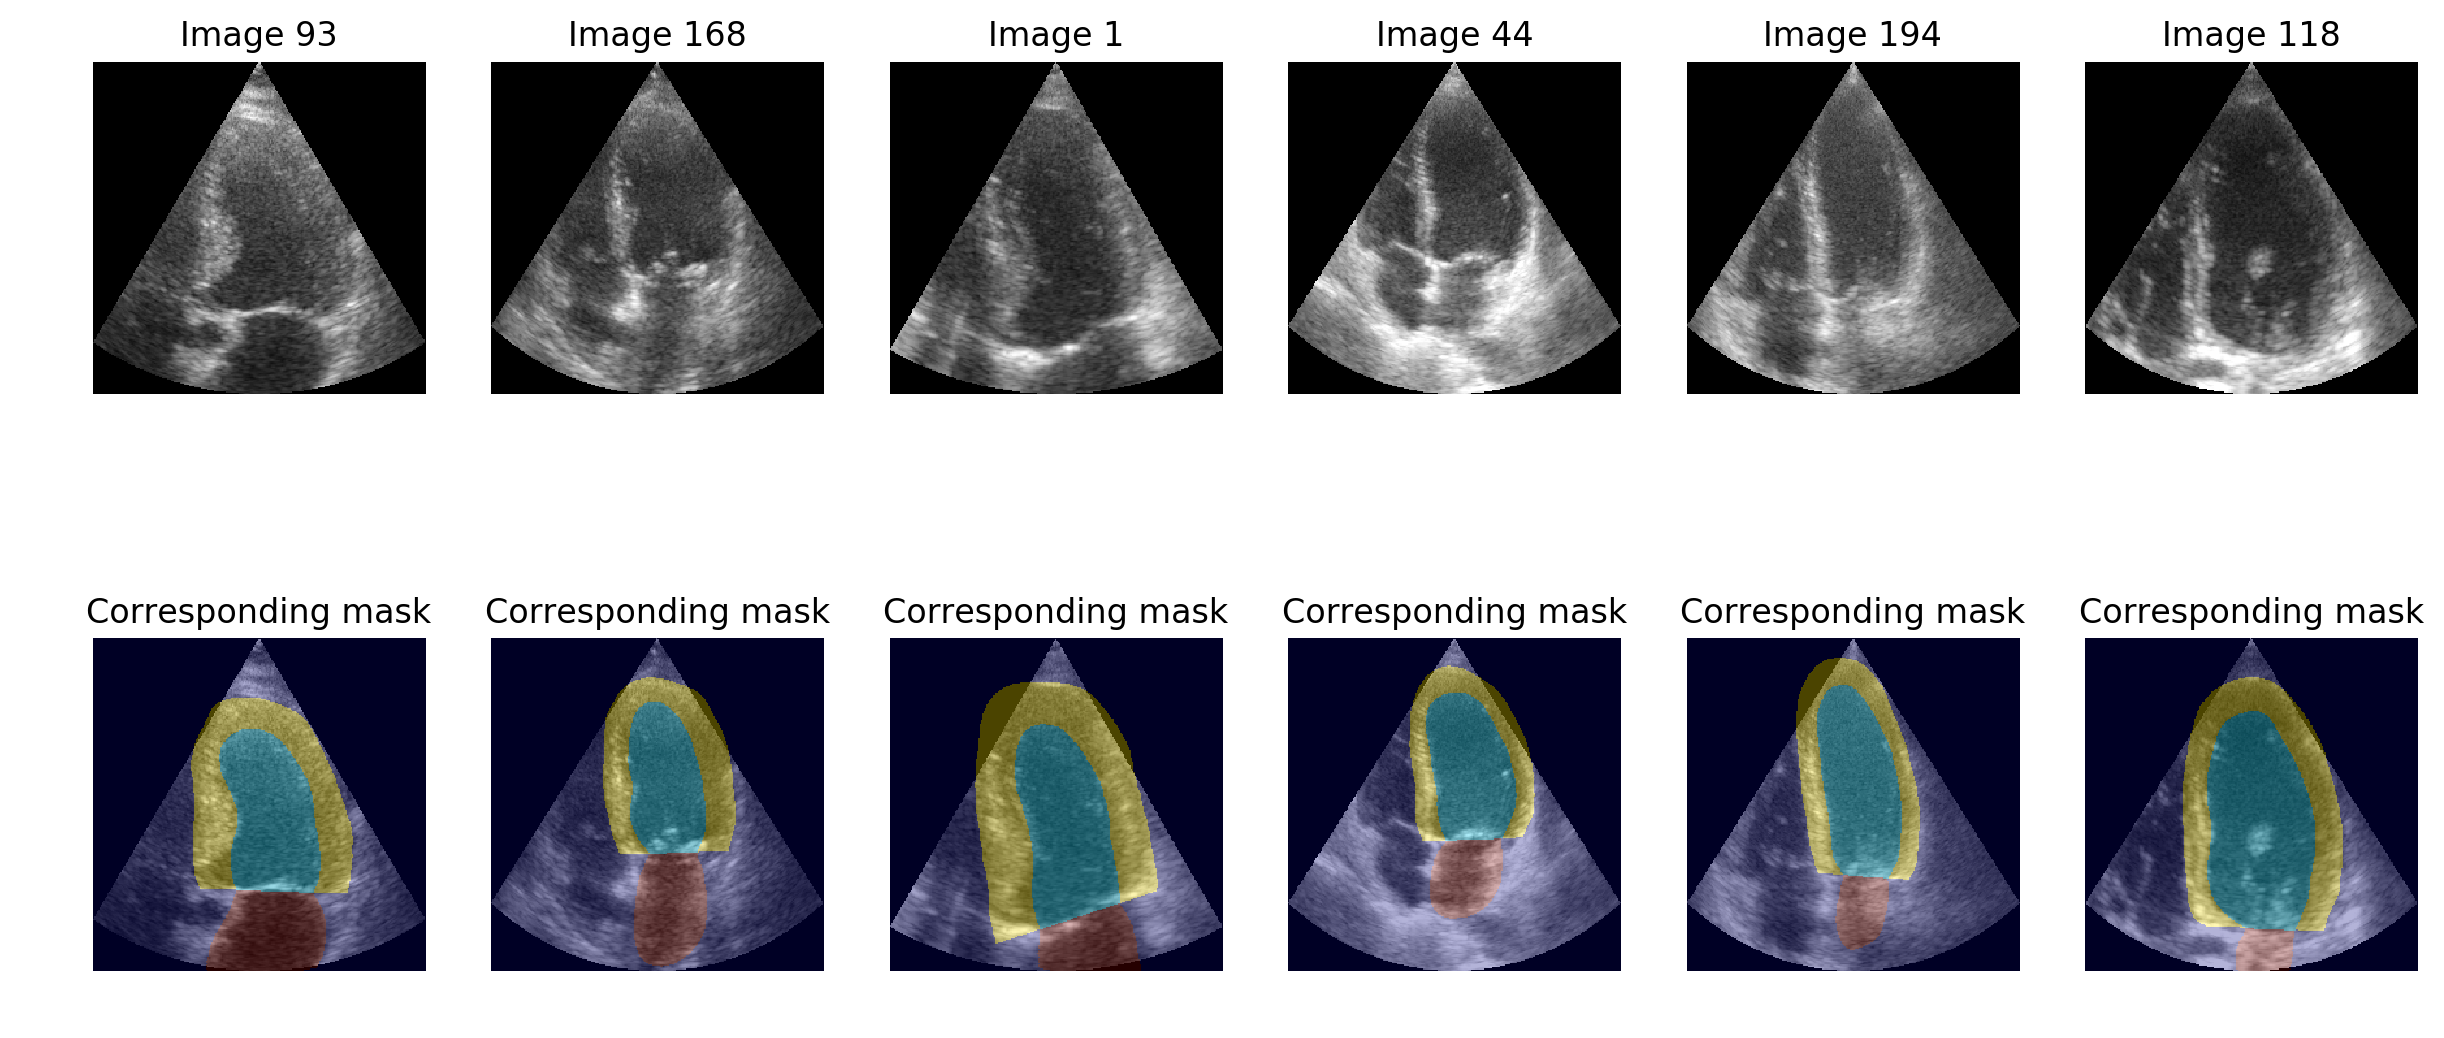

In [20]:
nb_examples = 6
display_dataset_samples(nb_examples, x_train, y_train)

***

<a id='architecture_unet'></a>
## 3 - Definition of the architecture of a U-Net model
    => estimated time: 40 minutes

It is time to design our U-Net architecture from the Keras library ! This is done in our unet function coded in model.py. The prototype of this function is given below:

***<div align="center">def unet(input_size=(256, 256, 1), ori_nb_fm=16, pretrained_weights=None, use_bn=True, show_summary=False)):</div>***

It takes several arguments as input:

- ***input_size***: size of the input image provided to the network. By default this value is set to (256,256,1).
- ***ori_nb_fm***: the original number of filter maps, that linearly evolves through the U-net. The feature maps are the output of a convolutional neural network. By default this value was set to 16 but it is often set at higher values to have larger networks with more parameters.
- ***pretrained_weights***: provides parameters that have been already trained. By default the *None* value is set, meaning that the network has to be trained from scratch.
- ***show_summary***: flag used for the display of the summary of the generated network (Keras function)  


**Excercice**: Analyse the unet function given in the *model.py* file from the file explorer. In particular try to understand the overall definition of the network and draw a parallel with the U-Net diagram provided at the beginning of this hands-on session.


**Comments**:
- The functions *Convolution2D*, *BatchNormalization*, *Activation*, *MaxPooling2D* and *UpSampling2D* all belong to the Keras library.
- Concerning the *Convolution2D* function, the different arguments correspond to: 
    - the number of features produced as output;
    - the (x,y)-size of the convolution kernel;
    - the padding used to deal with the intrinsic border effect of the convolution operation;
    - the stride at which the convolution is applied;
    - the type of initialization to perform on the underlying parameters.

To better understand those arguments, we provide below a diagram which summarizes the calculations that are performed on these layers (this diagram was taken from the official U-Net website from the university of Freiburg).

<img src="notebook_illustrations/convolution_layer.png" style="width:868px;height:364px;">


**Instructions**: Execute the unet function and analyze the corresponding summary by running the cell below. 

In [24]:
model = unet(input_size=(256, 256, 1), ori_nb_fm=10, use_bn=False, show_summary=True) # let's visualize the architecture to begin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 256, 10) 100         input_4[0][0]                    
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 256, 256, 10) 0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 256, 256, 10) 910         activation_55[0][0]              
__________________________________________________________________________________________________
activation

**Questions**: From the diagram given above, can you justify the number of parameters corresponding to the first convolution layer that appear in the summary ? Same question but with the second convolution layer.

***

<a id='training_phase'></a>
## 4 - Training phase
    => estimated time: 40 minutes

Now that you are familiar with the dataset and the definition of the unet architecture, it is time to learn the model from the training dataset. 

To this aim, we now have to focus our efforts on the following fundamental steps:
- Definition of the optimization process
- Assessment of the learning process
- Evaluation of the derived model on the training and validation datasets


### 4.1 - Definition of the optimization process

There are several parameters that have to be defined to set up an optimization scheme in deep learning. Among the most important, we can mention:

- ***batch size***: number of images used during one iteration (one forward/backward pass) of the optimization process
- ***number of epochs***: number of times the optimization process goes through entire training set
- ***learning rate***: dividing factor applied to the loss gradients to adapt the steps towards the optimum
- ***optimization algorithm***: there exists different algorithms to perform the optimization process, the most used being the Adam's optimizer
- ***loss function***: function that will be minimized during the optimization process
- ***metric functions***: functions that will be computed during the optimization process to see there evolution. These functions usually provide information on the quality of the segmentation but are not used to update the network parameters.


**Instructions**: Configure the optimization parameters by running the cell below. Feel free during the hands-on session to play with these parameters and study their influence.



In [26]:
batch_size = 10      # How many images per optimization step
nb_epochs = 50      # How many times do we feed in the entire training set
learning_rate = 5e-4 # dividing factor applied to the loss gradients : take small step towards the optimum 
gradient_optimizer = Adam(learning_rate)   # weights updating algorithm
loss_function = 'categorical_crossentropy' # function that will be minimized during the learning process
our_metrics = [multiclass_dice]       # functions that provide information on the quality of the segmentation

**Instructions**: To define the optimization parameters chosen for the deep learning model under Keras, it is necessary to use the *compile* function associated to the Keras model. Run the cell below to launch such a function.

In [27]:
model = unet(input_size=(256, 256, 1), pretrained_weights = None)
model.compile(loss=loss_function,
              optimizer=gradient_optimizer,
              metrics=our_metrics)

**Comments**: Under Keras, we can set up callback functions that are linked to the model. These callback functions are useful to set important properties and additional functionalities during the learning process. In this hands-on session, we will use two different callback functions:

- ***ModelCheckpoint***: this is a Keras function which allows the configuration of the instances where the current parameter values throughout the learning process are saved
- ***LossHistory***: this is a callback function that we have coded in the *utils.py* file which allows the saving of the evolution of the loss and metric functions over the learning process. As you will see, the corresponding graph are extremely useful to assess the behavior of the training phase


**Instructions**: We will use the two aformentioned callback functions for our project. In particular, we will use the ModelCheckPoint function to save the best parameters values throughout the training phase based on the loss obtained on the validation dataset. Run the cell below to define and link these two callback function to the model.


In [28]:
# The best model will be saved under the unet.h5 file    
model_name = 'unet.h5'
save_dir = os.path.join(os.getcwd(), 'models')
model_path = os.path.join(save_dir, model_name)

# Callback to save the best model 
save_best = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1
    )

# Callback to keep track of losses and metrics
history = LossHistory()

<br>

**CONGRATULATIONS !** You have completed all the necessary steps to configure a deep learning model in Keras. As you can see, thanks to high-level libraries such as tensorflow/keras, this can be easily done !

**Instructions**: This is time to launch your first learning process in order to fit the training dataset by running the cell below. 

In [29]:
# To train a model, use the fit Keras function attached to a model 
f = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=nb_epochs,
              validation_data=(x_val, y_val),
              shuffle=True,
              verbose=2,
              callbacks=[save_best, history],
        )

Train on 200 samples, validate on 100 samples
Epoch 1/50
 - 27s - loss: 1.3107 - multiclass_dice: 0.2601 - val_loss: 1.3633 - val_multiclass_dice: 0.3690
Epoch 2/50
 - 7s - loss: 0.8319 - multiclass_dice: 0.3553 - val_loss: 1.1352 - val_multiclass_dice: 0.3721
Epoch 3/50
 - 7s - loss: 0.6792 - multiclass_dice: 0.4275 - val_loss: 0.6992 - val_multiclass_dice: 0.4191
Epoch 4/50
 - 7s - loss: 0.5959 - multiclass_dice: 0.4822 - val_loss: 0.5614 - val_multiclass_dice: 0.5120
Epoch 5/50
 - 7s - loss: 0.5364 - multiclass_dice: 0.5161 - val_loss: 0.5251 - val_multiclass_dice: 0.5141
Epoch 6/50
 - 7s - loss: 0.4784 - multiclass_dice: 0.5502 - val_loss: 0.4762 - val_multiclass_dice: 0.5442
Epoch 7/50
 - 7s - loss: 0.4338 - multiclass_dice: 0.5770 - val_loss: 0.4463 - val_multiclass_dice: 0.5573
Epoch 8/50
 - 7s - loss: 0.3947 - multiclass_dice: 0.6016 - val_loss: 0.4123 - val_multiclass_dice: 0.5709
Epoch 9/50
 - 7s - loss: 0.3584 - multiclass_dice: 0.6264 - val_loss: 0.4196 - val_multiclass_dic

**Questions**: Have a look at the output values computed at each epoch. Analyze these values and interpret their variations throughout the learning process. 


### 4.2 - Assessment of the learning process

The most effective way to evaluate the learning process (*i.e.* to see how the training went) is to display and analyze the loss and metric curves stored using to the callback function *LossHistory* described above.

**Instructions**: Display the loss and metric curves corresponding to the learning process you just executed by running the cell below. For those interested with Python programming, don't hesitate to analyze the code of the *display_loss_metric_curves* function defined in the file *utils.py*.


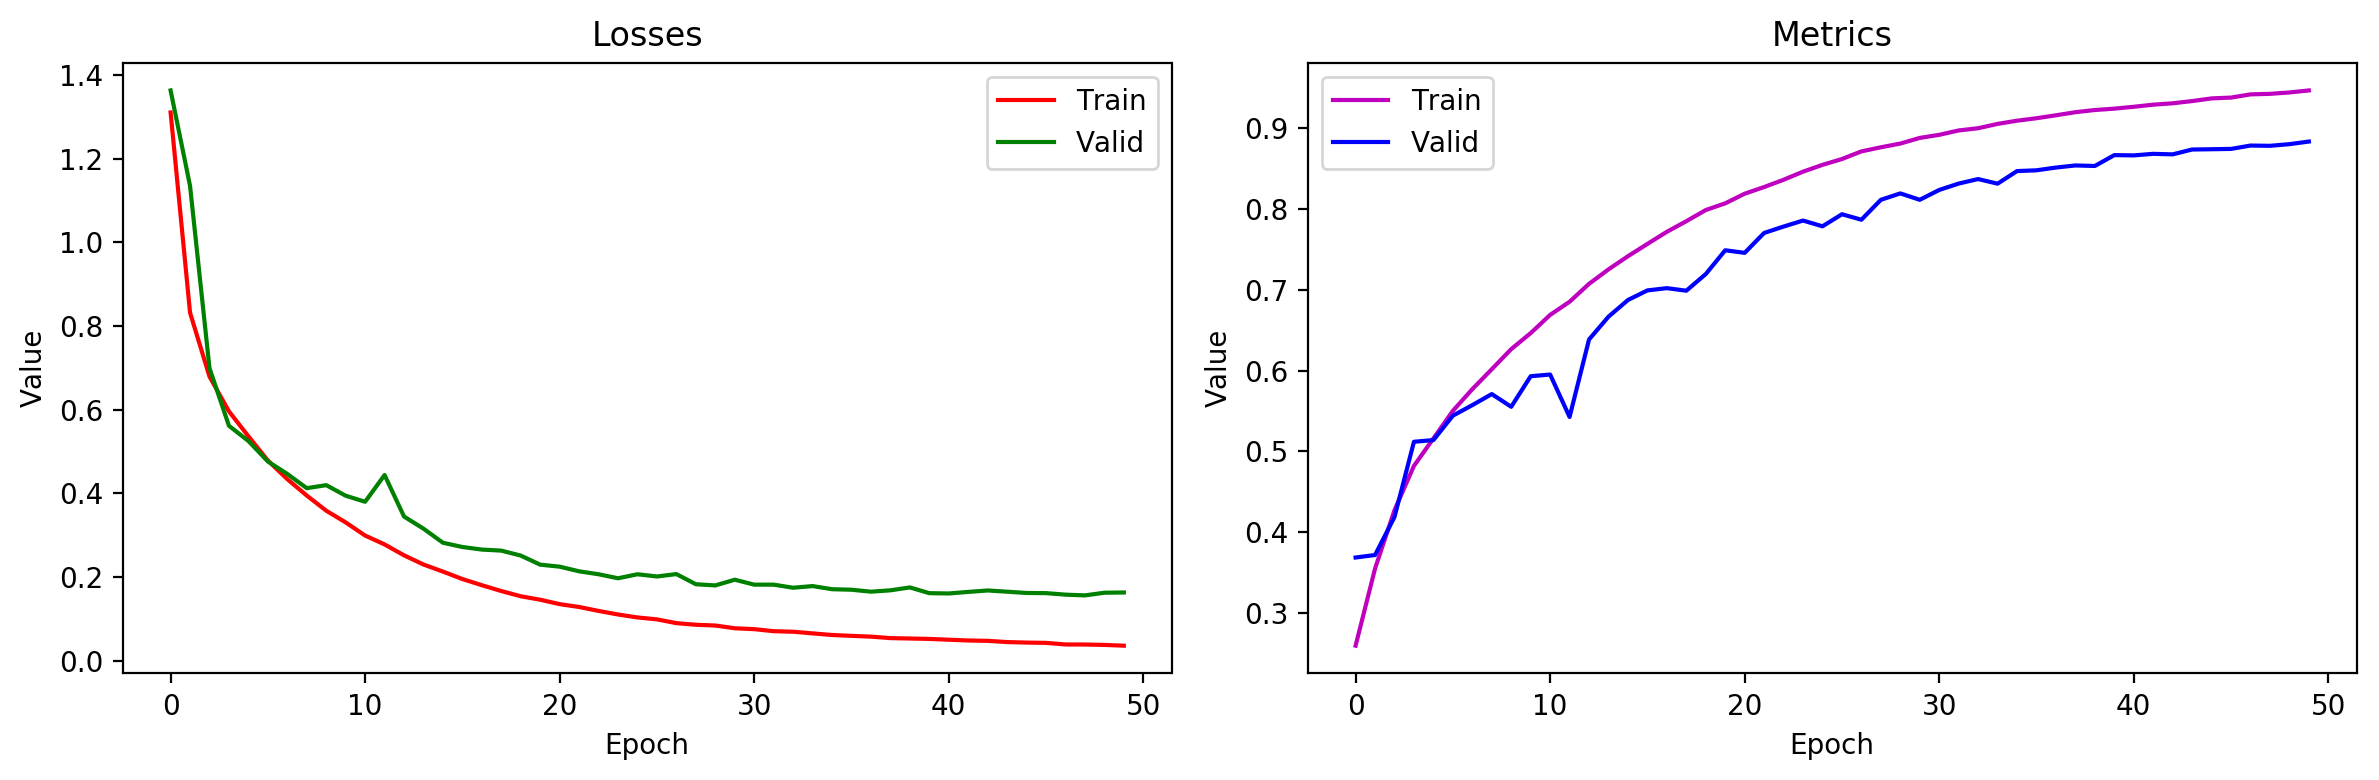

In [30]:
save_fig_dir = os.path.join(os.getcwd(), 'figures') # folder where to save the png file corresponding to the computed curves
save_fig_filename = 'first_unet_train.png'   # filename of the png file saved in the folder defined above
display_loss_metric_curves(nb_epochs, history, save_fig_dir, save_fig_filename) # our own function to display loss and metric curves

**Questions**: 

- What information can you retrieve from these curves ? 
- Why is it important to use a validation set ? 
- Why don't we use directly the testing dataset instead ?



### 4.3 - Evaluation of the trained U-Net on the training and validation datasets

The loss and metric functions we used to assess the learning process are not sufficient to evaluate the performance of the learned network on the training and validation dataset. Usually, studies involving additional and complementary metrics are carried out.

In segmentation domain, the standard metrics used to assess the geometrical quality corresponds to the Dice similarity index, Hausdorff distance (HD) and the average symmetric surface distance (ASSD) whose definitions are given below:

- ***Dice similarity index***: defined as $D=2\left(\left|S_{user}\cap S_{ref}\right|\right)/\left(\left|S_{user}\right|+\left|S_{ref}\right|\right)$. It is a measure of overlap between the segmented surface $S_{user}$ extracted from a method and the corresponding reference surface $S_{ref}$. The Dice index gives a value between 0 (no overlap) and 1 (full overlap)
- ***Hausdorff distance (HD)***: measures the local maximum distance between two surfaces
- ***Average Symmetric Surface Distance (ASSD)***: corresponds to the average distance between two surfaces

In addition, segmentations obtained from a deep learning model can contain small isolated regions that are falsely detected. To overcome these issues, some post processing steps based on morphological operators or some connected component analysis are usually applied.

**Instructions**: Run the cell below to calculate the metrics defined above on the training dataset and using the previously learned model.


In [31]:
# Constants used for evaluation
use_pp = True # Use post-processing on the prediction 
Metrics = ['Dice', 'HD (mm)', 'ASSD (mm)']
Structs = ['LV', 'Myo', 'LA']

# Run evaluation on the training set
train_res, train_seg = get_geometrical_results(model, x_train, y_train, data_path, train_ind, use_pp)

# Display average results
display_mean_values_of_metrics(train_res, Metrics, Structs)


200/200 [==============================] - 4s 22ms/step



Metric ['Dice', 'HD (mm)', 'ASSD (mm)']
LV :  [0.98 1.5  0.34]
Myo :  [0.97 1.79 0.35]
LA :  [0.98 1.44 0.33]


**Questions**: By taking into account that the resolution of an image acquired by a standard echocardiographic equipement is around 1 $mm^2$, analyze the accuracy of the obtained results.


**Comments**: The average performance alone doesn't say much about the network's robustness. It is therefore preferable to plot the distributions of values for all metrics.

**Instructions**: Run the cell below to compute and display the distribution of values for the three metrics.

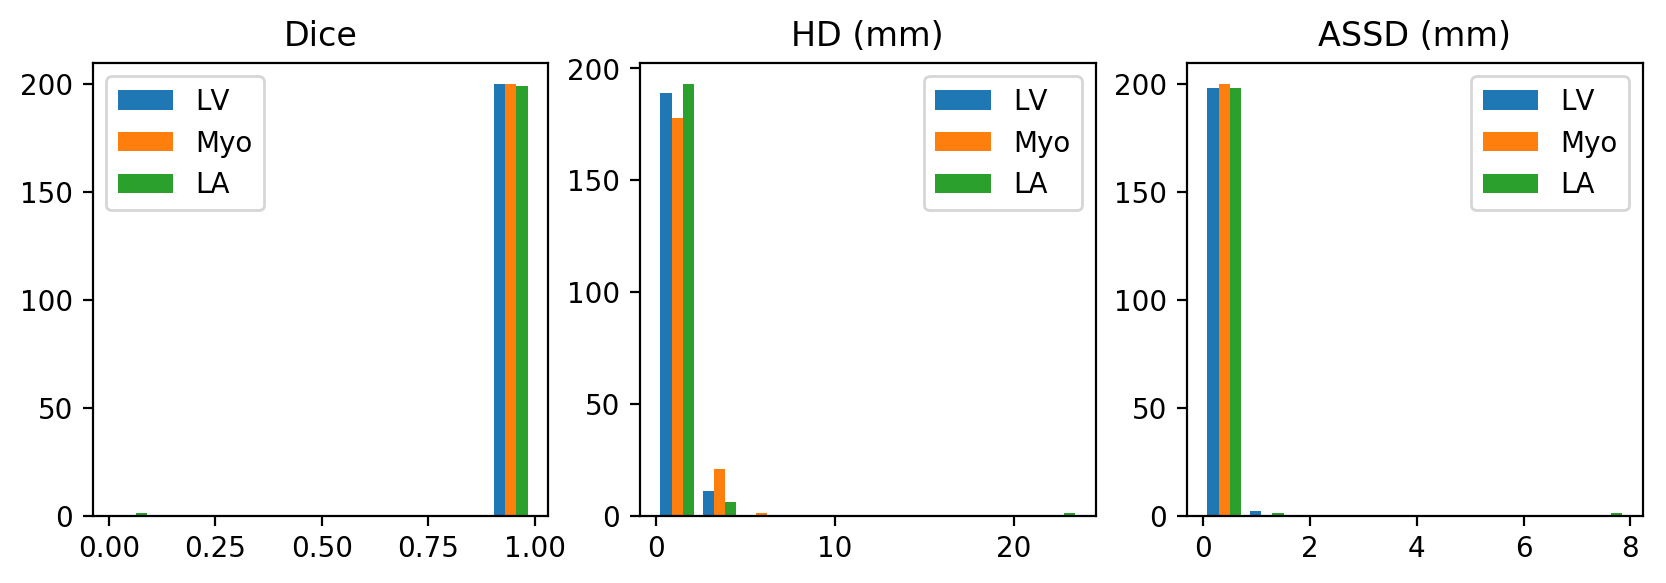

In [32]:
# Display histograms 
display_histogram_of_metrics(train_res, Metrics, Structs)

**Instructions**: It is now the time to look at the performance of our network on the validation dataset. Run the cell below to both compute the average score of your network on the validation dataset and display the corresponding histograms. 

100/100 [==============================] - 1s 14ms/step



Metric ['Dice', 'HD (mm)', 'ASSD (mm)']
LV :  [0.93 5.79 1.7 ]
Myo :  [0.85 7.32 1.79]
LA :  [0.89 6.55 2.  ]


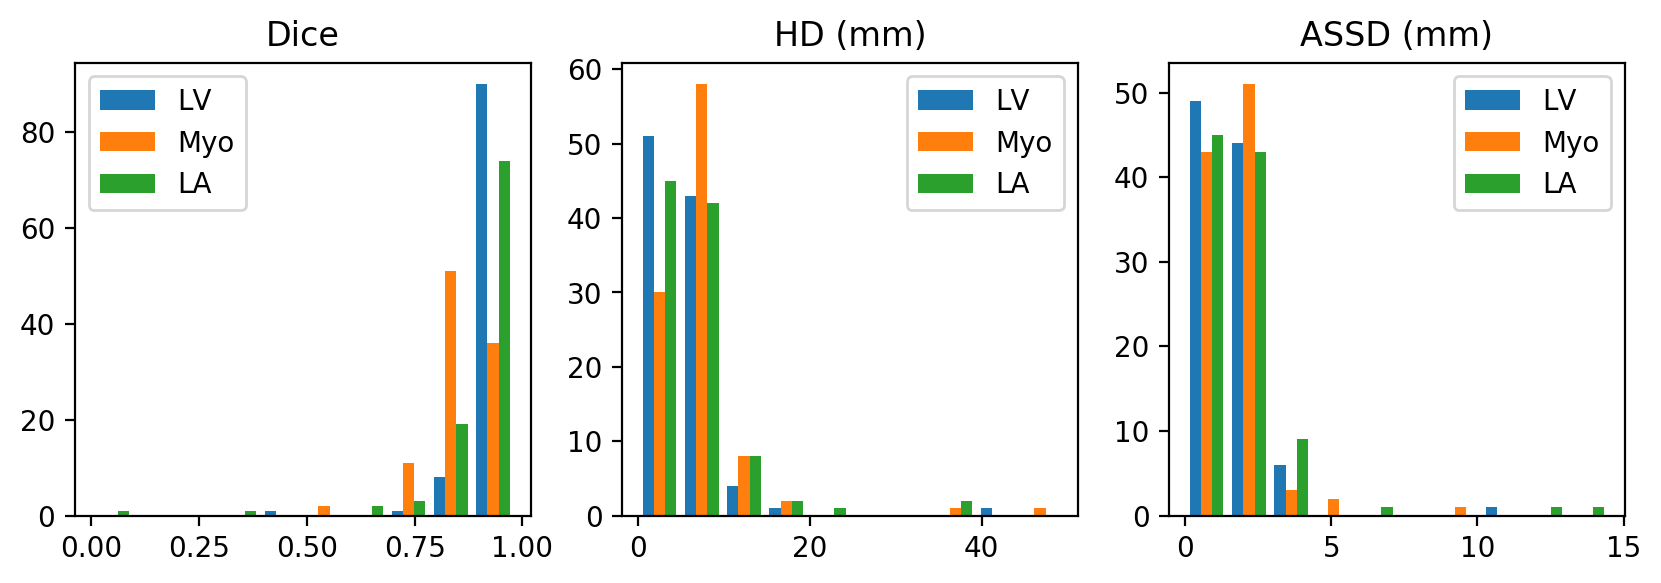

In [33]:
# Run evaluation on the validation set
val_res, val_seg = get_geometrical_results(model, x_val, y_val, data_path, val_ind, use_pp)

# Display average results
display_mean_values_of_metrics(val_res, Metrics, Structs)

# Display histograms 
display_histogram_of_metrics(val_res, Metrics, Structs)

**Questions**: Compare the overall performance of your U-Net model obtained on the training and the validation datasets. Do you see any differences ? If so, can you explain them ?

### 4.4 - Evaluation of the trained U-Net on the testing dataset

Now that you have trained your U-Net model and that you have observed that the learning process was carried out correctly, this means that your architecture should behave well on new data. This is why we have created the testing dataset. Indeed, your network has not seen any data of this set so far and we will test the network's ability to generalize to it. The final scores you will get for this dataset are the ones that you will need to keep to assess the performance of your network.


**Instruction**: Run the cell below to both compute the average score of your network on the testing dataset and display the corresponding histograms

100/100 [==============================] - 1s 8ms/step



Metric ['Dice', 'HD (mm)', 'ASSD (mm)']
LV :  [0.93 5.16 1.54]
Myo :  [0.86 6.93 1.64]
LA :  [0.9  5.73 1.8 ]


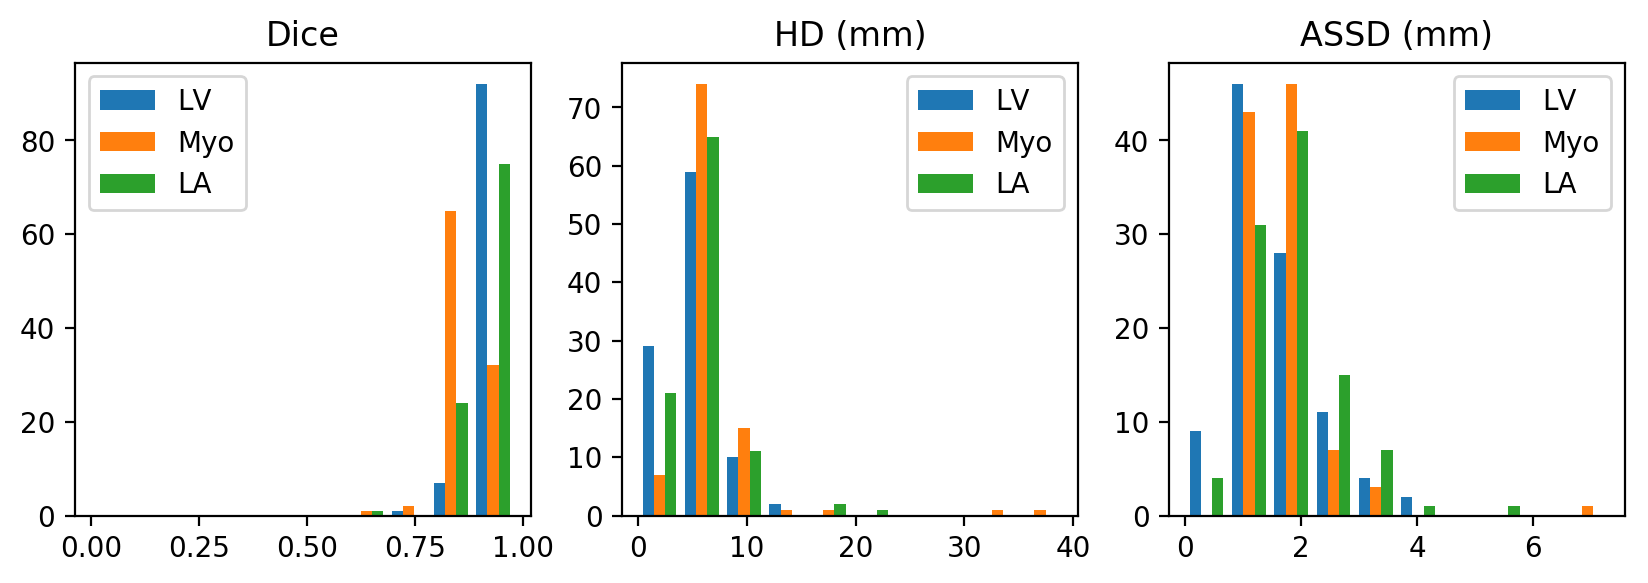

In [34]:
# Run evaluation on the testing set
test_res, test_seg = get_geometrical_results(model, x_test, y_test, data_path, test_ind, use_pp)

# Display average results
display_mean_values_of_metrics(test_res, Metrics, Structs)

# Display histograms 
display_histogram_of_metrics(test_res, Metrics, Structs)

**Questions**: Compare the overall performance of your U-Net model obtained on the validation and the testing datasets. Can we say we picked a good validation set ? Where do the biases come from ?

**Instructions**: To have a complete overview of the performance the learned network, assess visually the model predictions on samples from the testing dataset by running the cell below. Feel free re-run the cell multiple times to see other images. For those interested with Python programming, don't hesitate to analyze the code of the *display_dataset_samples_with_estimation* function defined in the file *utils.py*.


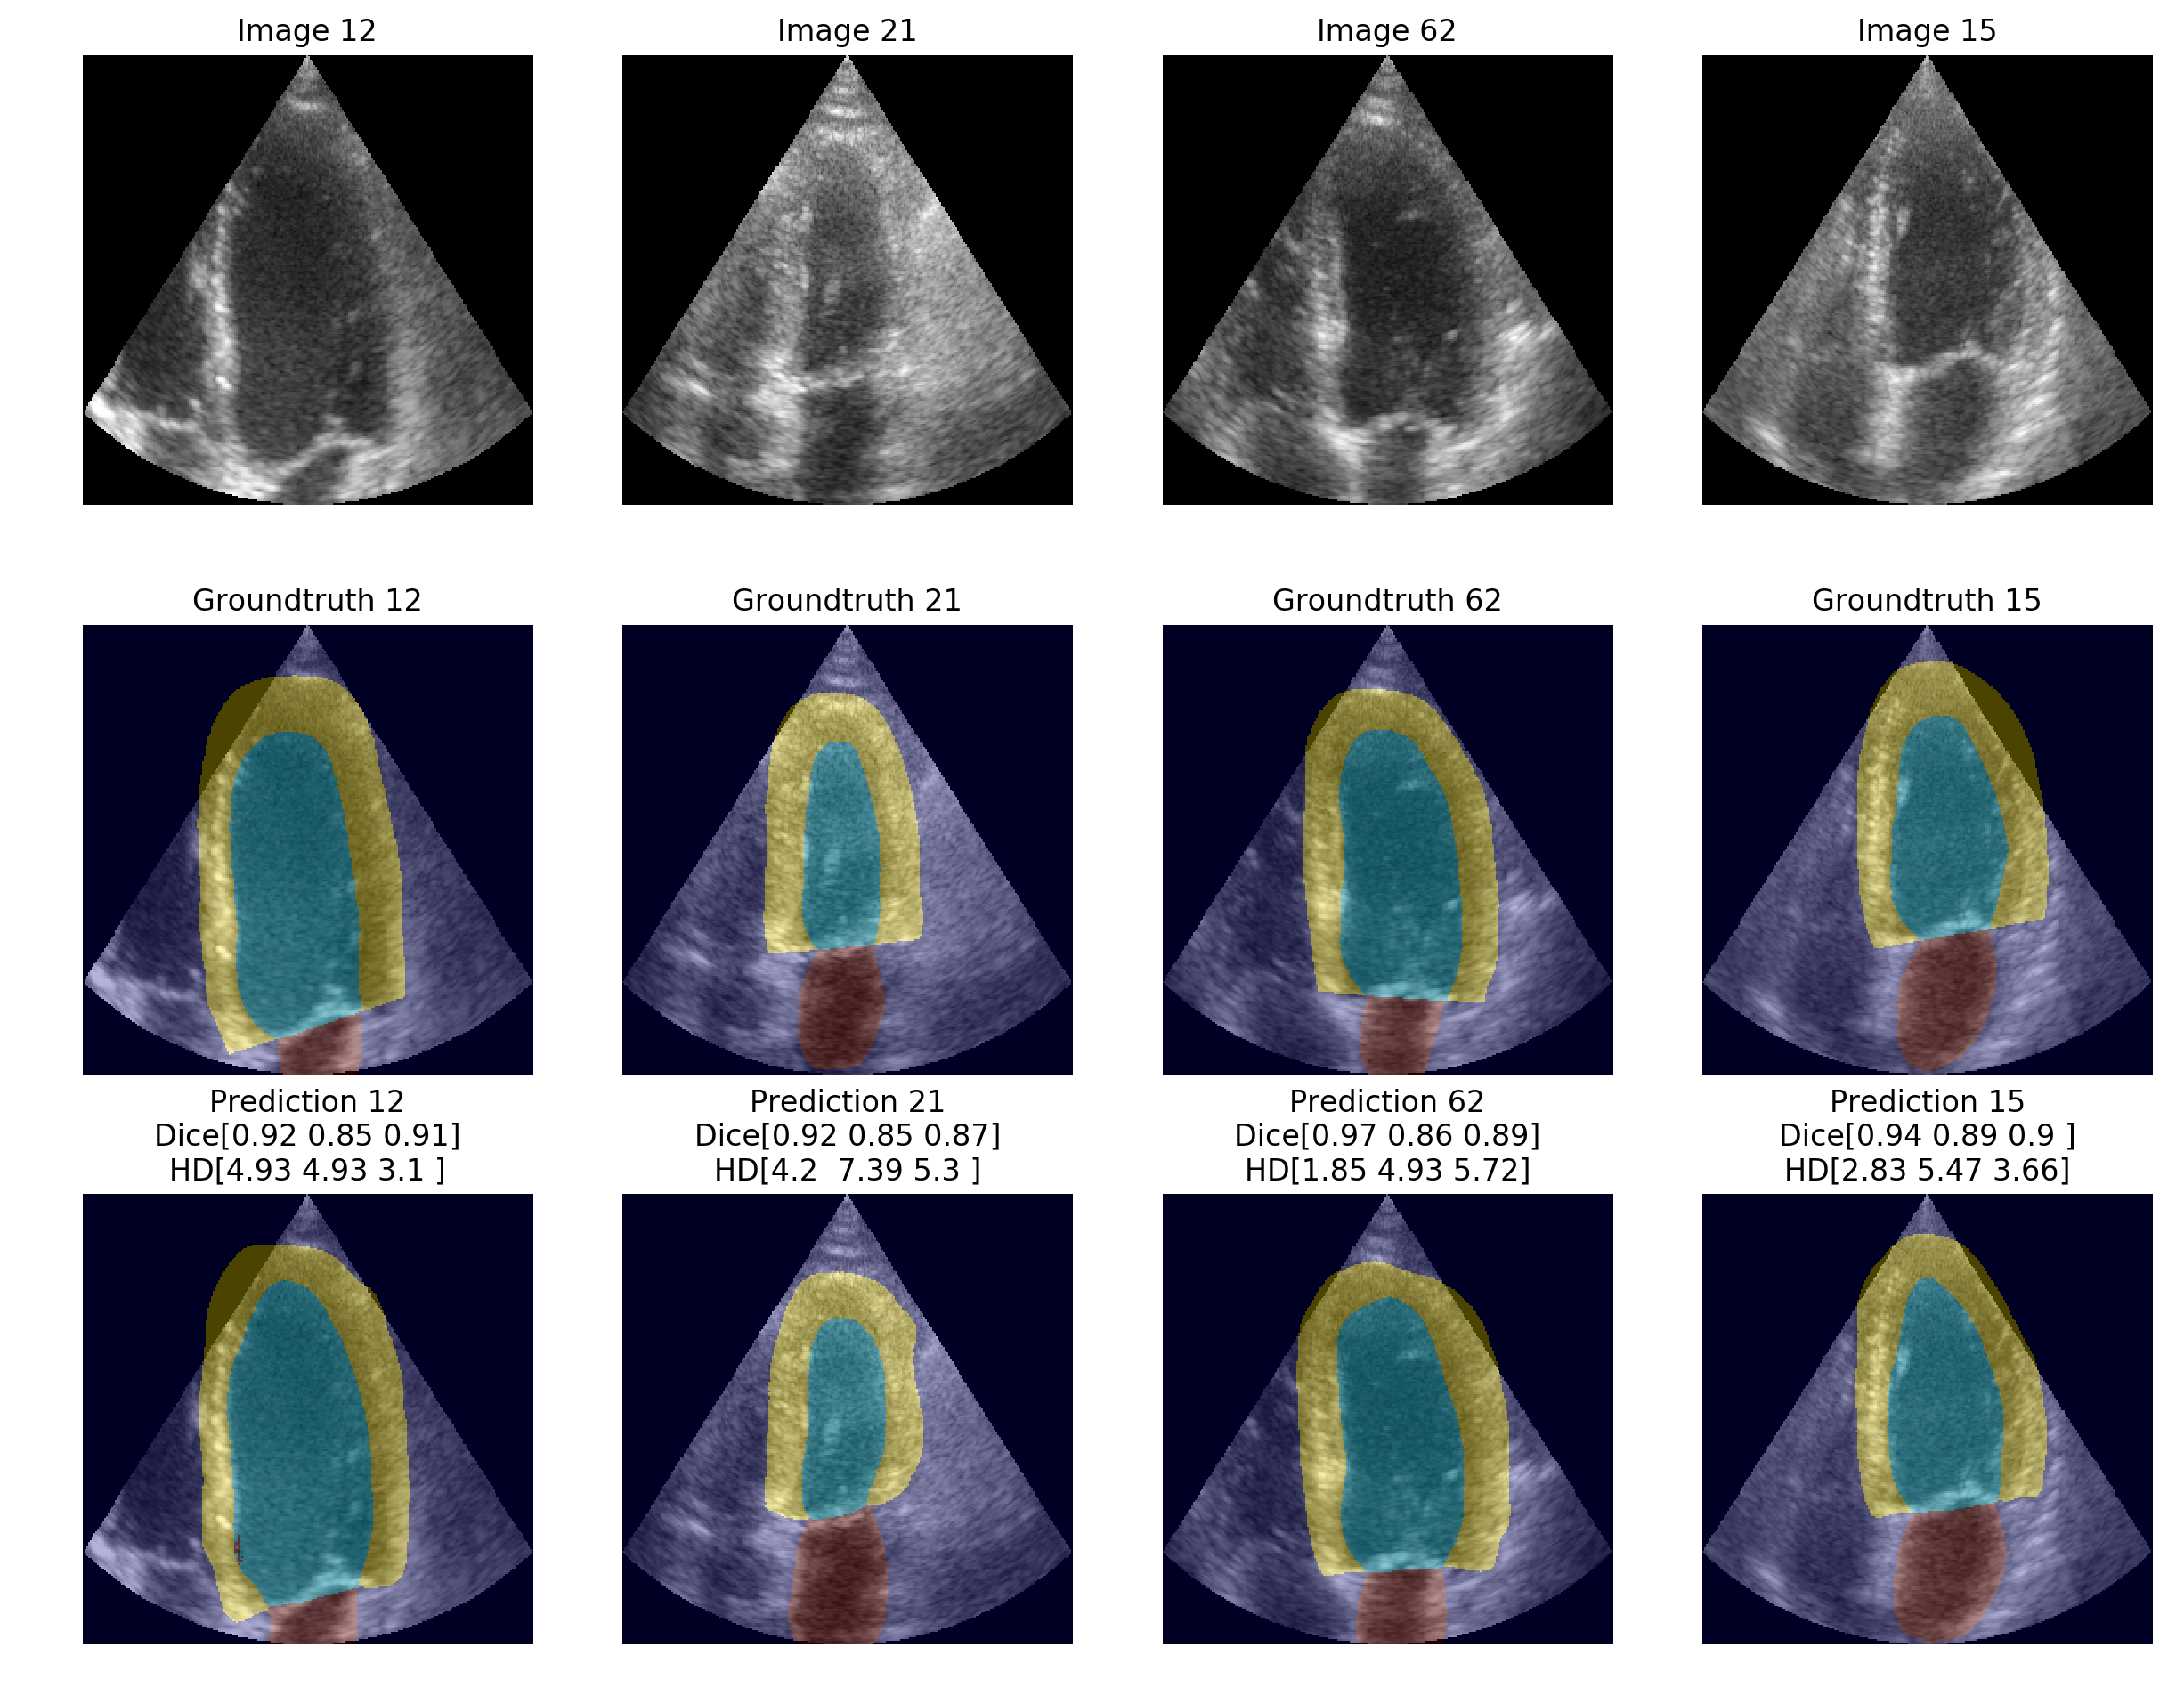

In [35]:
# visualize predictions on samples randomly selected from the testing dataset
nb_examples = 4
display_dataset_samples_with_estimation(nb_examples, x_test, y_test, test_seg, test_res)

**Questions**: Are you convinced visually by the obtained results ? What kind of additional tests are missing to be able to say that the model is ready for clinical applications ?

<br>

**Comments**: You can directly load a pre-trained model fom the unet function by passing as argument the filename of the corresponding weights that have been saved. For instance the cell below allows to load a pre-trained model from the file named *pretrained_unet_fh.h5*.

In [36]:
model = unet(input_size=(256, 256, 1), pretrained_weights='/floyd/input/camus_pretrained_models/pretrained_unet_fh.h5')

model.compile(loss=loss_function,
              optimizer=gradient_optimizer,
              metrics=our_metrics)

Model loaded with pretrained weights


***

<a id='training_optimization'></a>
## 5 - Training optimization 
    => estimated time: 30 minutes
    
In this part of the hands-on session, you will study the influence of important hyper-parameters involved in the learning process by playing with their values. Due to the limited time, we restrict this study to the following parameters:

- ***learning rate***: dividing factor used during the optimization process and applied to the loss gradients to adapt the steps towards the optimum

- ***batch size***: number of samples propagated through the network before each weight update

**Exercice**: 

1. Run the cell below with the activation of the batch normalization and by playing with different values of the learning rate. We advise you to test learning rate values between 1e-1 and 1e-4 for 30 epochs. What happens ?


Train on 200 samples, validate on 100 samples
Epoch 1/30
 - 13s - loss: 0.8027 - multiclass_dice: 0.2851 - val_loss: 3.8952 - val_multiclass_dice: 0.2156
Epoch 2/30
 - 7s - loss: 0.6274 - multiclass_dice: 0.3254 - val_loss: 3.8951 - val_multiclass_dice: 0.2156
Epoch 3/30
 - 7s - loss: 0.5813 - multiclass_dice: 0.3785 - val_loss: 3.8803 - val_multiclass_dice: 0.2158
Epoch 4/30
 - 7s - loss: 0.6042 - multiclass_dice: 0.3535 - val_loss: 3.8952 - val_multiclass_dice: 0.2156
Epoch 5/30
 - 7s - loss: 0.5165 - multiclass_dice: 0.3857 - val_loss: 3.8554 - val_multiclass_dice: 0.2180
Epoch 6/30
 - 7s - loss: 0.4708 - multiclass_dice: 0.4291 - val_loss: 3.6801 - val_multiclass_dice: 0.2310
Epoch 7/30
 - 7s - loss: 0.4250 - multiclass_dice: 0.4611 - val_loss: 2.8206 - val_multiclass_dice: 0.3130
Epoch 8/30
 - 7s - loss: 0.4162 - multiclass_dice: 0.4831 - val_loss: 3.7243 - val_multiclass_dice: 0.2212
Epoch 9/30
 - 7s - loss: 0.3798 - multiclass_dice: 0.5004 - val_loss: 3.3304 - val_multiclass_dic

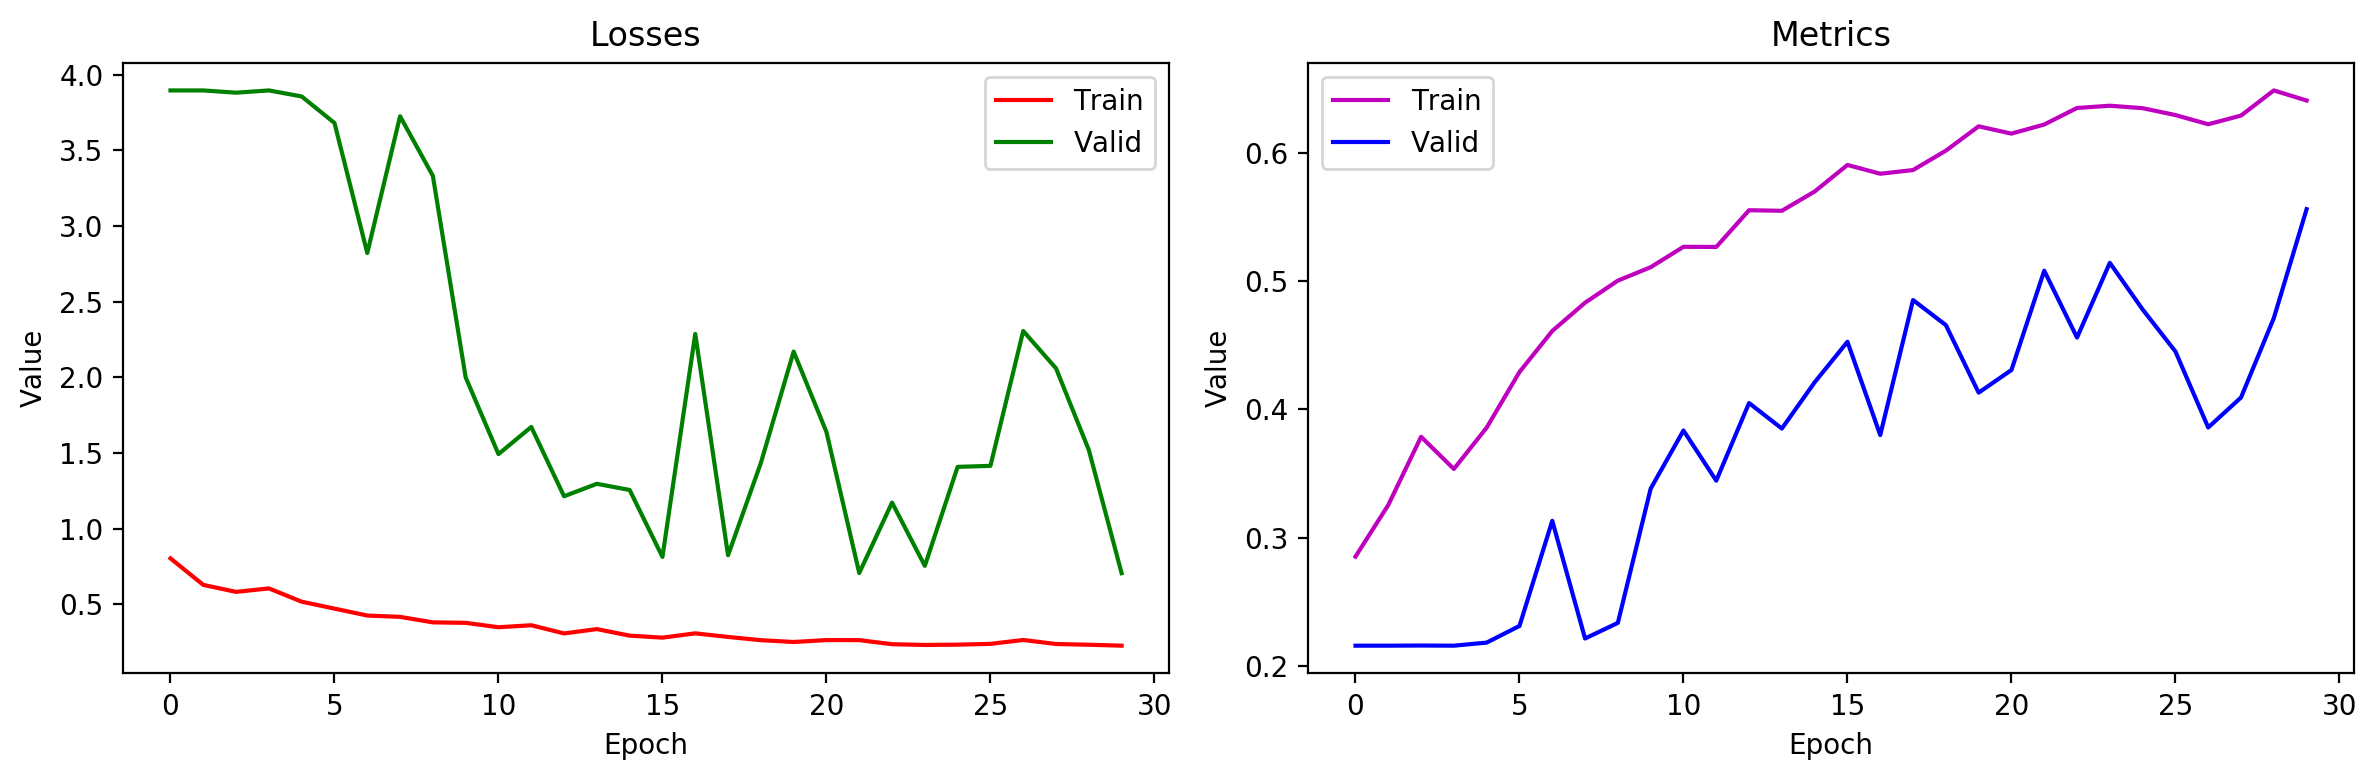

In [38]:
# Hyperparameters to tune
learning_rate = 5e-1

# Fix parameters 
flag_batch_norm = True
nb_initial_feature_map = 16
batch_size = 10
nb_epochs = 30
gradient_optimizer = Adam(learning_rate)
loss_function = 'categorical_crossentropy'

# store details in a string
details = ('unet' + '_lr_' + str(learning_rate) + '_loss_' + str(loss_function) +
'_batch_size_' + str(batch_size) + '_epochs_' + str(nb_epochs) + '.png')

# compile model 
model = unet(input_size=(256, 256, 1), pretrained_weights = None)
model.compile(loss=loss_function,
              optimizer=gradient_optimizer,
              metrics=our_metrics)

# prepare saving of the model
model_name =  details + '.h5'
model_path = os.path.join(save_dir, model_name)

# callback functions
save_best = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1
    )
history = LossHistory()

# Train model
f = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=nb_epochs,
              validation_data=(x_val, y_val),
              shuffle=True,
              verbose=2,
              callbacks=[save_best, history],
        )

# Save and display results
save_fig_dir = os.path.join(os.getcwd(), 'figures') # folder where to save the png file corresponding to the computed curves
save_fig_filename = details                         # filename of the png file saved in the folder defined above
display_loss_metric_curves(nb_epochs, history, save_fig_dir, save_fig_filename) # our own function to display loss and metric curves



***

<a id='unet_optimization'></a>
## 6 - U-Net architecture optimization 
    => estimated time: 30 minutes
    
In this part of the hands-on session, you will study the influence of important parameters involved in the U-Net architecture by playing with their values. Due to the limited time, we restrict this study to the following parameters:

- ***number of initial feature maps***: feature maps correspond to the output of the convolution kernels applied at a specific layer. In the U-Net architecture we use, the number of feature maps are double when switching from one layer to another. Thus, the number of feature maps for all layers is fixed by the number of initial feature maps applied to the first layer. 


- ***batch normalization***: dividing weights that have to be learned so to normalize the dynamic of activation per convolutional kernels. This processing has a regularization effect on the network. 

**Exercices**: 

1. Run the cell below with the batch normalization activated, a learning rate of 1e-3, a number of epoch of 30 and by doubling the original number of feature maps (i.e. 16). What are the consequence on the model ? What can be observed on the training and validation losses ?


2. Run the cell below with the original number of feature maps (i.e. 16), a learning rate of 1e-3, a number of epoch of 10 and by playing with the activation of the batch normalization. What are your observations on the training curves ? You can have a look to the following website to analyze these results: https://www.quora.com/Why-does-batch-normalization-help)



Train on 200 samples, validate on 100 samples
Epoch 1/30
 - 15s - loss: 1.2278 - multiclass_dice: 0.2724 - val_loss: 3.8952 - val_multiclass_dice: 0.2156
Epoch 2/30
 - 7s - loss: 0.7209 - multiclass_dice: 0.3104 - val_loss: 3.8952 - val_multiclass_dice: 0.2156
Epoch 3/30
 - 7s - loss: 0.6848 - multiclass_dice: 0.3119 - val_loss: 3.8952 - val_multiclass_dice: 0.2156
Epoch 4/30
 - 7s - loss: 0.6714 - multiclass_dice: 0.3109 - val_loss: 3.8902 - val_multiclass_dice: 0.2156
Epoch 5/30
 - 7s - loss: 0.6647 - multiclass_dice: 0.3101 - val_loss: 3.8952 - val_multiclass_dice: 0.2154
Epoch 6/30
 - 7s - loss: 0.6598 - multiclass_dice: 0.3142 - val_loss: 3.8484 - val_multiclass_dice: 0.2189
Epoch 7/30
 - 7s - loss: 0.6527 - multiclass_dice: 0.3171 - val_loss: 2.8509 - val_multiclass_dice: 0.2699
Epoch 8/30
 - 7s - loss: 0.6454 - multiclass_dice: 0.3181 - val_loss: 1.1880 - val_multiclass_dice: 0.3306
Epoch 9/30
 - 7s - loss: 0.6450 - multiclass_dice: 0.3203 - val_loss: 0.7721 - val_multiclass_dic

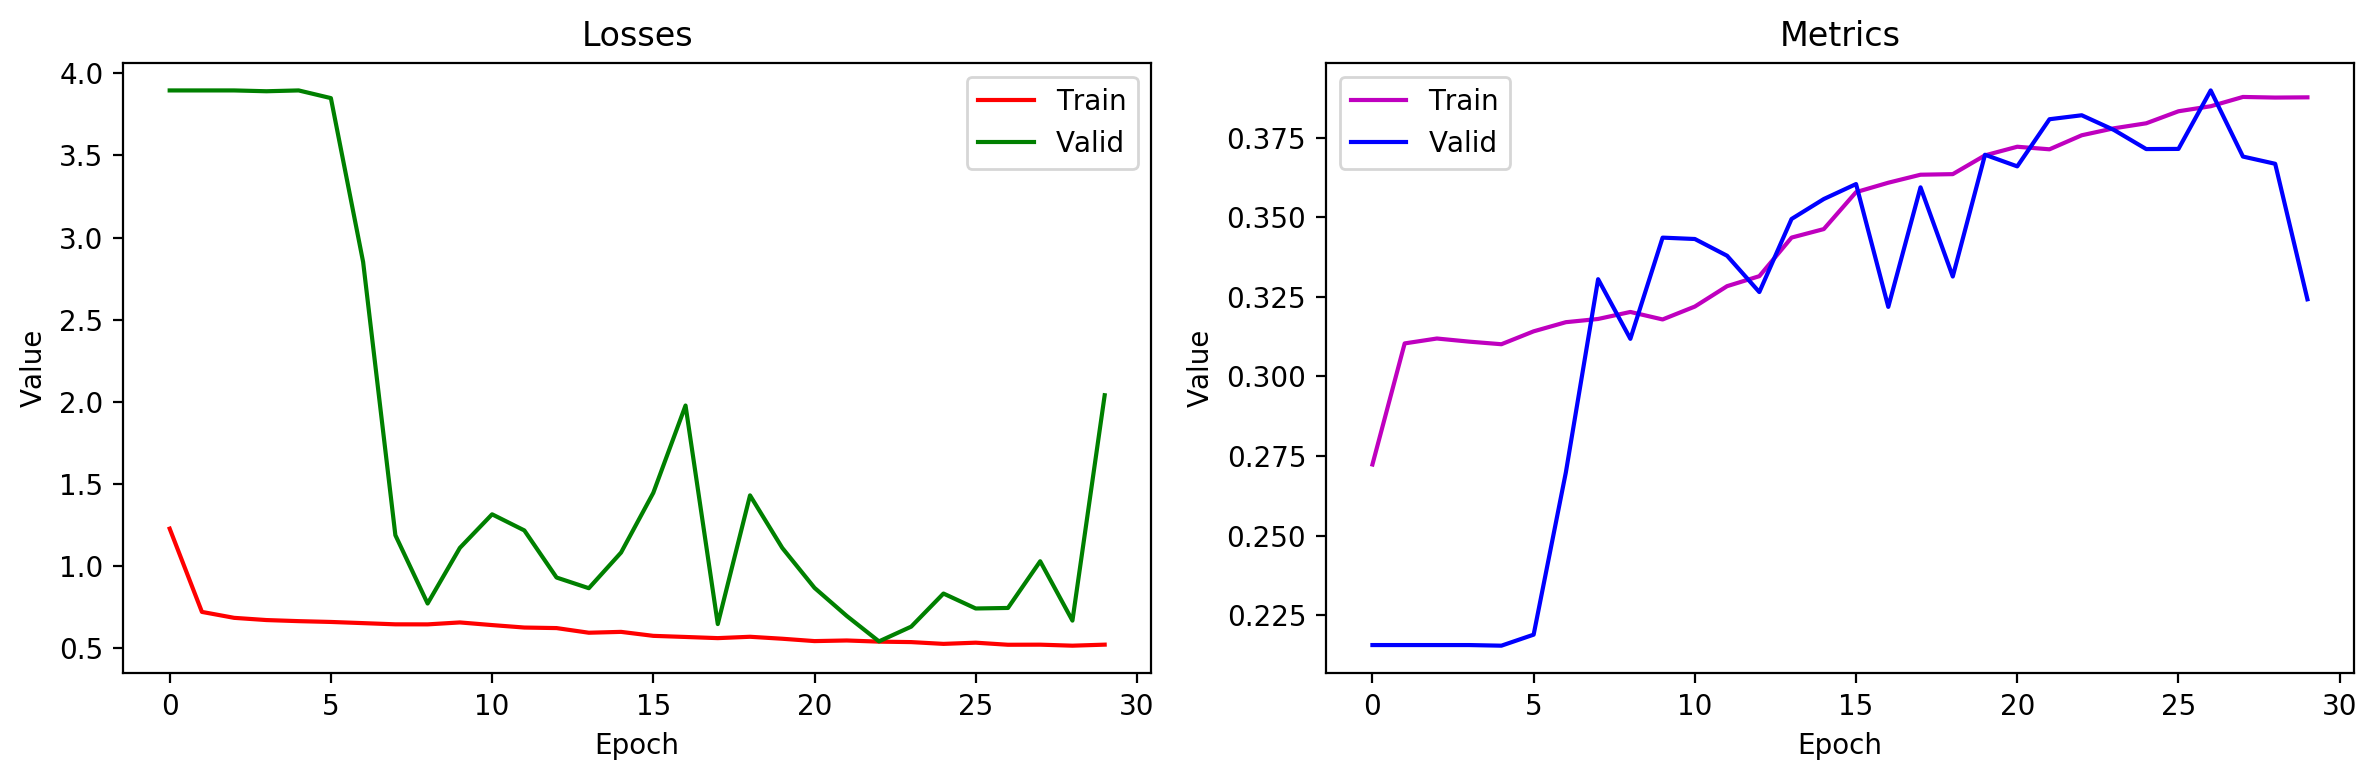

In [40]:
# Hyperparameters to tune
flag_batch_norm = True
nb_initial_feature_map = 25

# Fix parameters 
learning_rate = 1e-3
batch_size = 10
nb_epochs = 30
optimizer = Adam(learning_rate)
loss = 'categorical_crossentropy'

# store details in a string
details = ('unet' + '_lr_' + str(learning_rate) + '_loss_' + str(loss) +
'_batch_size_' + str(batch_size) + '_epochs_' + str(nb_epochs) )

# compile model 
model = unet(input_size=(256, 256, 1), pretrained_weights = None)
model.compile(loss=loss_function,
              optimizer=gradient_optimizer,
              metrics=our_metrics)

# prepare saving of the model
model_name =  details + '.h5'
model_path = os.path.join(save_dir, model_name)

# callback functions
save_best = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1
    )
history = LossHistory()

# Train model
f = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=nb_epochs,
              validation_data=(x_val, y_val),
              shuffle=True,
              verbose=2,
              callbacks=[save_best, history],
        )

# Save and display results
save_fig_dir = os.path.join(os.getcwd(), 'figures') # folder where to save the png file corresponding to the computed curves
save_fig_filename = details                         # filename of the png file saved in the folder defined above
display_loss_metric_curves(nb_epochs, history, save_fig_dir, save_fig_filename) # our own function to display loss and metric curves


***

<a id='to_go_further'></a>
## 7 - To go further
    => estimated time: remaining time :)


### 7-1 : Influence of the training set size 

As you would expect, the size of the training dataset is critical to the quality of the final results. Surprisingly, this property is not studied in most of the article you will find in the literature! In this part of the hands-on session, you will investigate the impact of such a parameter by evaluating the scores achieved by the U-Net model trained from a varying size of the training dataset (10, 20, 50, 70, 80, 90, 100). To save you time, we already trained such models using the following hyper-parameters: activation of the batch normalization, learning rate of 1e-3, a number of epoch of 30, a number of initial feature maps of 16. These models are present in the pretrained_model dataset if you wish to use them.

<img src="notebook_illustrations/inc_size.png" style="width:868px;height:364px;">


**Questions**: From the analysis of these curves, what conclusions can you draw about the size of the training dataset ? about the capacity of our network ?

***

### 7-2 : visualization of the feature maps

After the learning of a deep learning model, it is great not to consider it as a black box, but to study what is happening within its architecture. In this part of the hands-on session, you will look at intermediary feature maps, especially the first and the last layers.

**Instructions**: Run the cell below to visualize the first filters and feature maps that have been learned from a pre-trained network.


In [41]:
# get feature maps
model = unet(input_size=(256, 256, 1), pretrained_weights='/floyd/input/camus_pretrained_models/pretrained_unet_fh.h5')
layers = model.layers

Model loaded with pretrained weights



Size of the selected feature maps (1, 1, 16, 4)
4

Filters

Number of feature maps 4

Feature maps


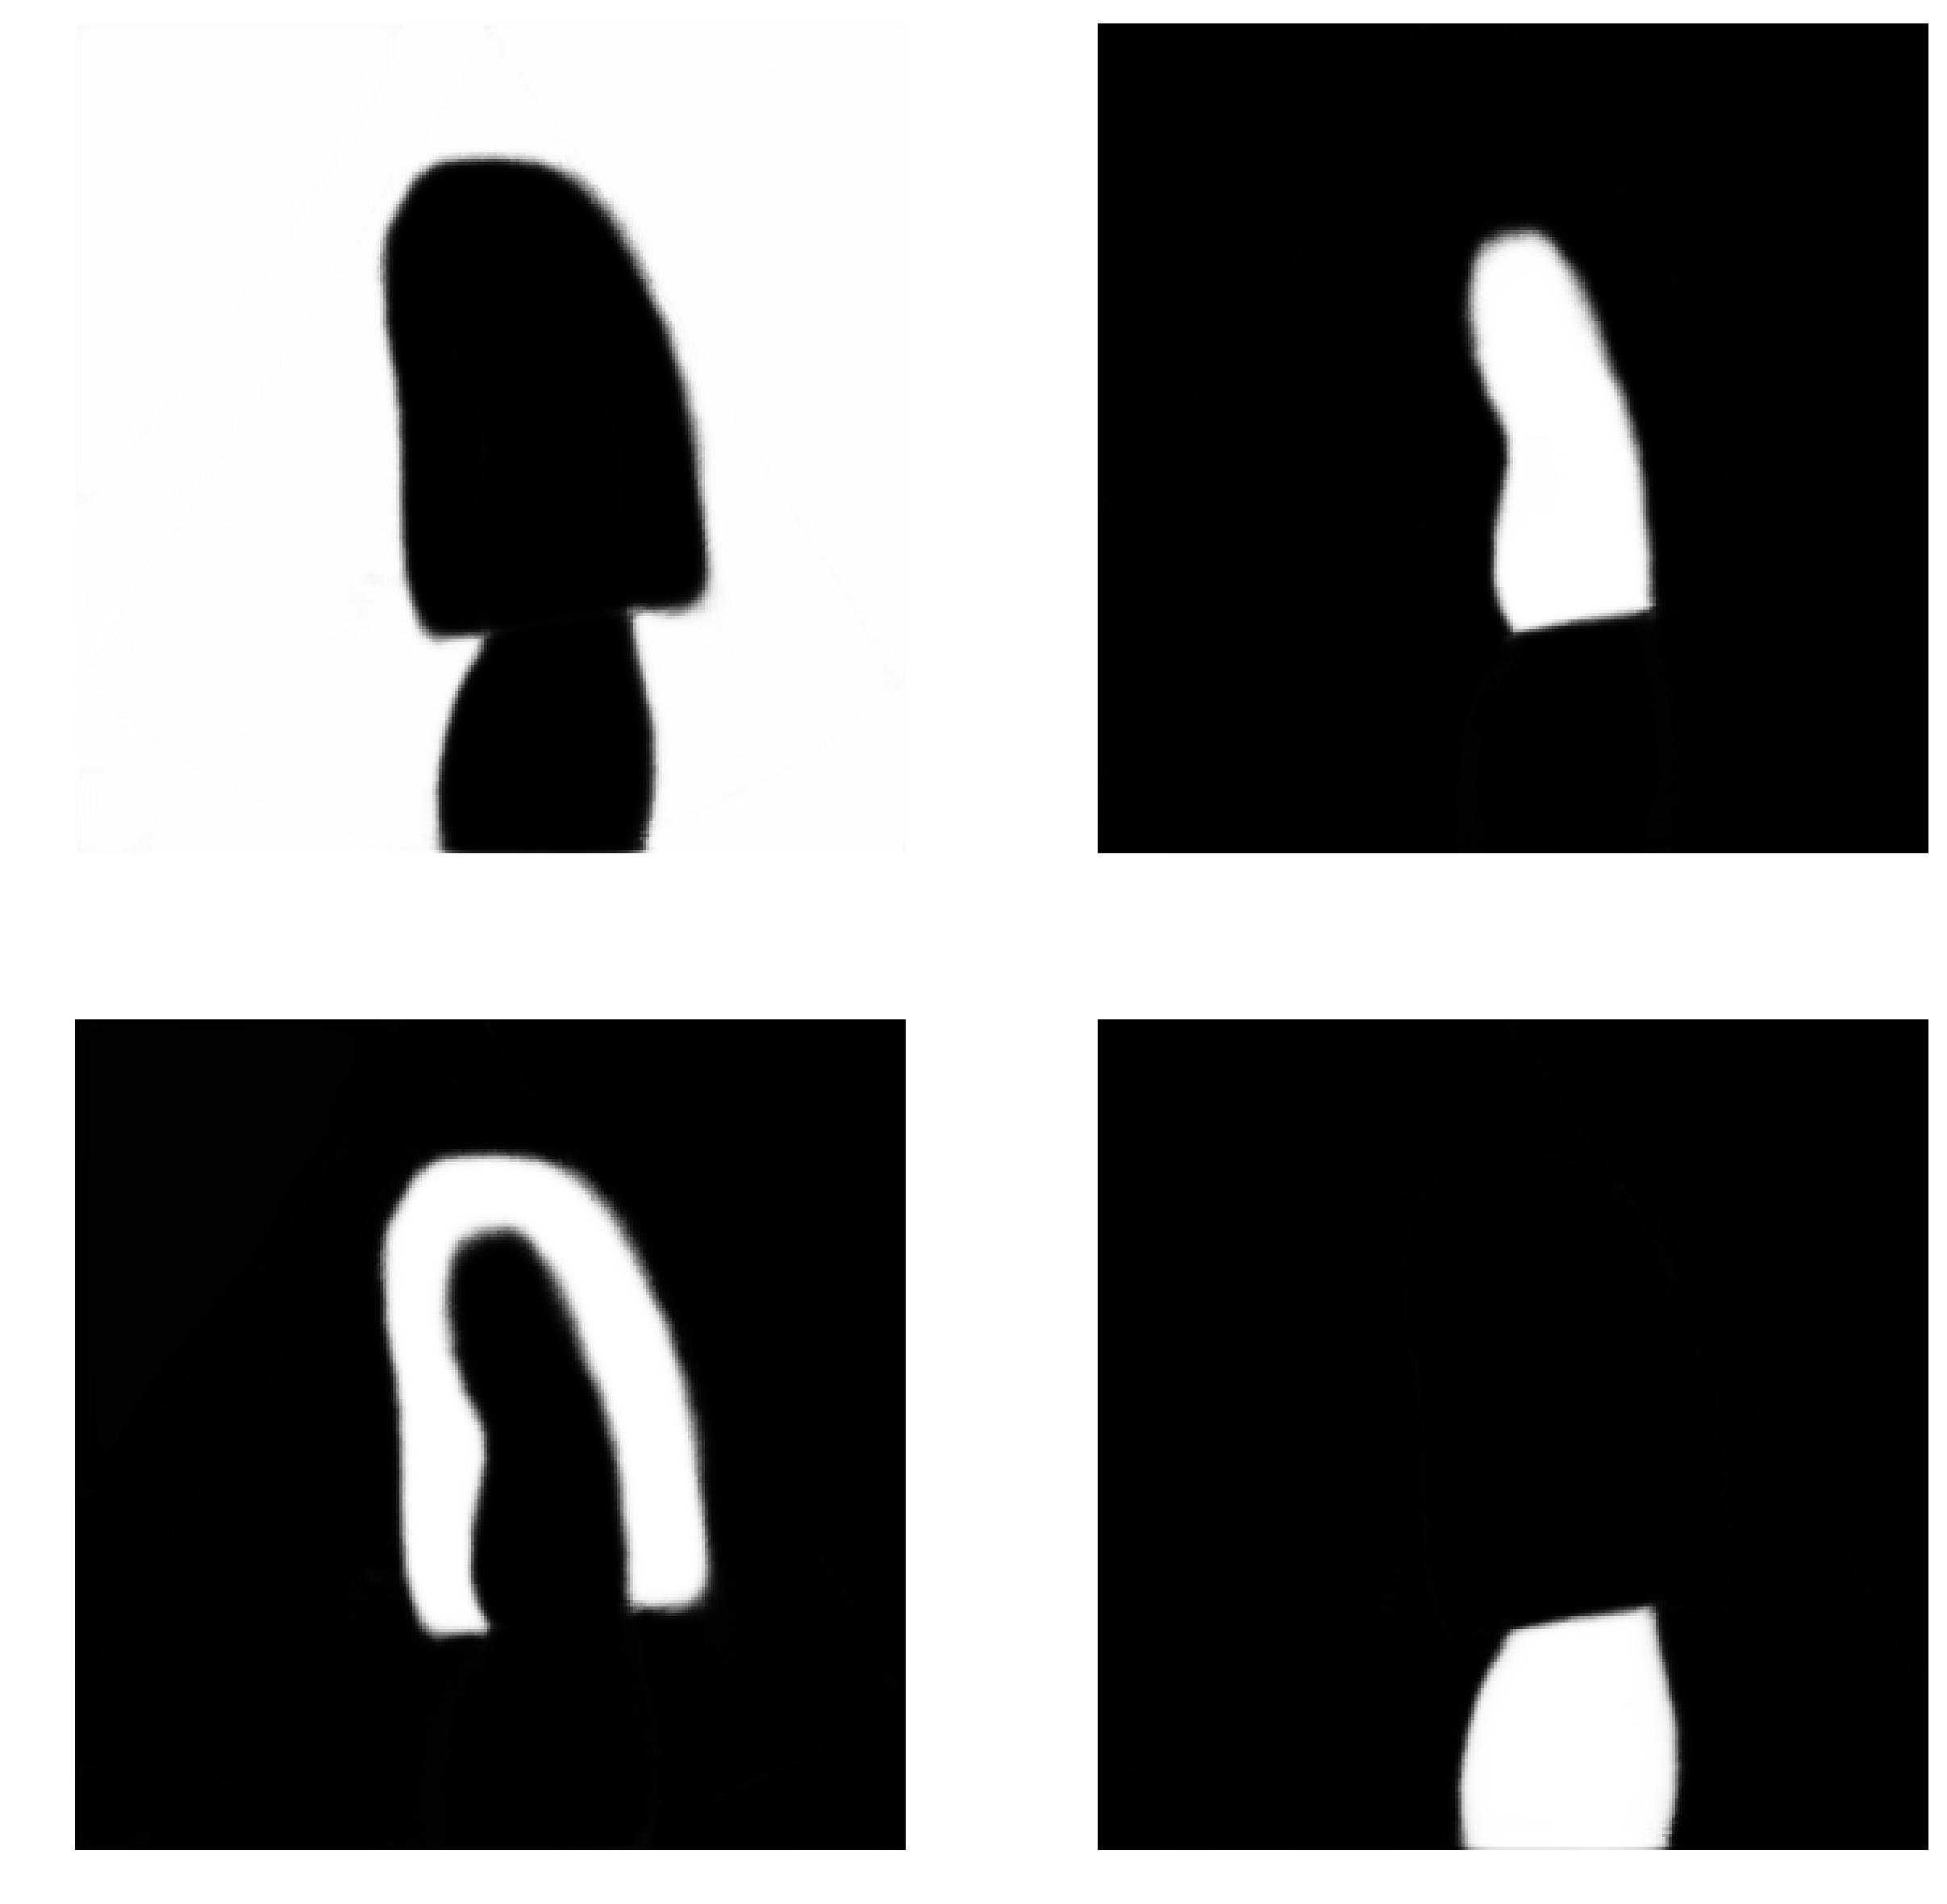

In [54]:
# select a specific layer weights and feature maps
feat_layer = layers[-1] # extract the first layer
weights = feat_layer.get_weights()[0] # extract the filters (not the biases at [1])
interm_model = Model(inputs=model.input, outputs=feat_layer.output)

# Apply the model on an image from the validation set
ind = np.random.randint(0, x_val.shape[0], 1)
feat_maps = interm_model.predict(x_val[ind].reshape(1, 256, 256, 1))
feat_maps = np.squeeze(feat_maps, axis=0)

# Display the size of the selected feature maps
print('\nSize of the selected feature maps', weights.shape)

# display weights applied to the first feature map of the previous layer
nb_feat = feat_maps.shape[-1]
print(nb_feat)
display_model_weights(weights, nb_feat)

# Display the number of feature maps
print('\nNumber of feature maps', nb_feat)

# Display the corresponding feature maps
display_model_feature_maps(feat_maps, nb_feat)


**Questions**: 

- Try to interpret the action that performs the learned filters on the input image. Change the previous code to visualize the feature maps for the second layer.

- To visualize the feature maps of the last layer, you simply have to change the third line of the previous code (feat_layer = layers[1]) by *feat_layer = layers[-1]*. Change the code accordingly and visualize the corresponding feature maps. What do these feature maps represent for the final segmentation task ?

***